
## Lab4: Introduction to Convolutional Layers

### The goal of this lab is to understand mathematical motivations and thought processes behind a wide range of
###  practical network augmentation approaches.

### For the specific task, we wanted to perform video classification.
### Unfortunately, video classification datasets are
### very data and compute expensive, and so rather than downloading 100GB of youtube videos for lab we are going
###  to simulate our own demo dataset.

### The specific techiques we will cover today will be:
### 1- Residual layers: https://arxiv.org/pdf/1512.03385.pdf
###     1a- Residual Bottlenecking layers (same paper)
### 2- Hidden Penalty layers (See Google's Inception or AlphaGo Zero)
### 3- Adversarial Sampling (https://www.youtube.com/watch?v=CIfsB_EYsVI)
### 4- (Optional) Recurrent networks with local connections and spatial
### parameter sharing https://arxiv.org/abs/1506.04214


In [1]:

# Import common dependencies
import torch
import pandas as pd  # noqa
import numpy as np
import matplotlib  # noqa
import matplotlib.pyplot as plt
import datetime  # noqa
import PIL  # noqa
import glob  # noqa
import pickle  # noqa
from pathlib import Path  # noqa
from torch import nn
from torch.nn import init
from torch.autograd import Variable  # noqa
from scipy import misc  # noqa



## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into trn and val


In [2]:


def process_mnist():
    import torchvision
    data = torchvision.datasets.MNIST(root='.', download=True)
    train_data = data.train_data.numpy()
    train_labels = data.train_labels.numpy()

    data_test = torchvision.datasets.MNIST(root='.', download=True, train=False)
    test_data = data_test.test_data.numpy()
    test_labels = data_test.test_labels.numpy()

    data = np.concatenate([train_data, test_data], axis=0)
    labels = np.concatenate([train_labels, test_labels], axis=0)

    return data, labels

In [3]:


data, labels = process_mnist()

Processing...
Done!


In [4]:


# Check the final shape of our in-use dataset
print('data shape', data.shape)

# Feature shapes
num_rows, num_features = data.shape[0], data.shape[1]

# Select Training rows
np.random.seed(0)
trn_rows = np.sort(np.random.choice(num_rows, size=int(num_rows * .7), replace=False))

# Select Validation rows
val_rows = np.setdiff1d(np.arange(num_rows), trn_rows)

# Split dataset
trn_data, val_data = data[trn_rows], data[val_rows]
trn_Y, val_Y = labels[trn_rows], labels[val_rows]

# already normalized when appropriate
# Normalize training and validation based on training data
data_max, data_min = trn_data.max(0), trn_data.min(0)
data_diff = data_max - data_min + 1e-18


def normalize_data(data, data_diff, data_min):
    normalized = (data - np.expand_dims(data_min, 0)) / np.expand_dims(data_diff, 0)
    return normalized


trn_normalized = np.expand_dims(normalize_data(trn_data, data_diff, data_min), -1)
val_normalized = np.expand_dims(normalize_data(val_data, data_diff, data_min), -1)
trn_normalized = np.transpose(trn_normalized, [0, 3, 2, 1])
val_normalized = np.transpose(val_normalized, [0, 3, 2, 1])


data shape (70000, 28, 28)


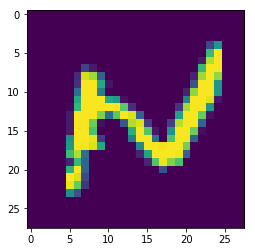

In [5]:

plt.imshow(trn_normalized[0, 0, :, :])

In [6]:
USE_CUDA = 1


def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj


def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs



### Lets Build some fancy network architectures!

In [7]:



class Residual(nn.Module):
    def __init__(self, filters, kernel_size, relu=True):
        nn.Module.__init__(self)
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels=filters, out_channels=filters,
                              kernel_size=kernel_size, stride=1, padding=padding)
        if relu:
            self.relu = nn.LeakyReLU()
        else:
            self.relu = False

    def forward(self, x):
        conv = self.conv(x)
        if self.relu:
            return self.relu(conv + x)
        else:
            return conv + x


class ResidualBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, kernel_size=3, relu=True):
        nn.Module.__init__(self)
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels,
                               kernel_size=1, stride=1, padding=0)

        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels,
                               kernel_size=kernel_size, stride=1, padding=padding)

        self.conv3 = nn.Conv2d(in_channels=hidden_channels, out_channels=out_channels,
                               kernel_size=1, stride=1, padding=0)

        if relu:
            self.relu = nn.LeakyReLU()
        else:
            self.relu = False

    def forward(self, x):
        conv = self.conv1(x)
        conv = self.relu(conv)
        conv = self.conv2(conv)
        conv = self.relu(conv)
        conv = self.conv3(conv)
        if self.relu:
            return self.relu(conv + x)
        else:
            return conv + x


class ResidualSpatialBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, kernel_size=3, relu=True):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels,
                               kernel_size=5, stride=2, padding=2)

        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels,
                               kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=out_channels,
                                        kernel_size=4, stride=2, padding=1)

        if relu:
            self.relu = nn.LeakyReLU()
        else:
            self.relu = False

    def forward(self, x):
        conv = self.conv1(x)
        conv = self.relu(conv)
        conv = self.conv2(conv)
        conv = self.relu(conv)
        conv = self.conv3(conv)
        if self.relu:
            return self.relu(conv + x)
        else:
            return conv + x



In [8]:

def init_weights(module):
    # Optional: Initialize weights using Xavier Initialization
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)


class Identity(nn.Module):
    # Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x


class Model(nn.Module):
    def __init__(self, input_shape, hidden_layers, num_outputs, lr=1e-4):
        # num_inputs is the number of input feature
        # Hidden layers is a list of hidden layer sizes
        nn.Module.__init__(self)
        self.output_layers = nn.ModuleList()
        self.input_shape = input_shape

        prev_filters = 1
        self.hidden_layers = nn.ModuleList()
        shape = input_shape
        self.trn_losses = []
        self.val_losses = []
        self.val_acc = []
        self.relu = nn.LeakyReLU()
        if 1:
            for idx, (filters, kernel_size, stride, padding, ltype) in enumerate(hidden_layers):
                if ltype == 'r':
                    if shape >= 14:
                        layer = ResidualSpatialBottleneck(
                            in_channels=prev_filters, out_channels=prev_filters,
                            hidden_channels=filters, kernel_size=kernel_size)
                    else:
                        layer = ResidualBottleneck(
                            in_channels=prev_filters, out_channels=prev_filters,
                            hidden_channels=filters, kernel_size=kernel_size)
                    self.hidden_layers.append(layer)
                elif ltype == 'c':
                    layer = nn.Conv2d(
                        in_channels=prev_filters, out_channels=filters, kernel_size=kernel_size,
                        stride=stride, padding=padding)
                    self.hidden_layers.append(layer)
                    prev_filters = filters
                if idx == 0:
                    self.first_layer = layer
                shape = shape // stride
                if padding == 0:
                    shape = shape - 1
                if (idx > 0) and (idx < len(hidden_layers) - 1) and (idx % 3) == 0:
                    flat_size = prev_filters * shape * shape
                    self.output_layers.append(nn.Linear(flat_size, flat_size//10))
                    self.output_layers.append(nn.LeakyReLU())
                    self.output_layers.append(nn.Linear(flat_size//10, num_outputs))
            flat_size = prev_filters * shape * shape
            self.output_layers.append(nn.Linear(flat_size, flat_size))
            self.output_layers.append(nn.LeakyReLU())
            self.output_layers.append(nn.Linear(flat_size, num_outputs))
        self.loss_fcn = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=lr, weight_decay=1e-8)
        init_weights(self)
        print(self.hidden_layers)

    def forward(self, x, y):
        batch_size = x.shape[0]
        hidden_loss_idx = 0
        x = tovar(x, requires_grad=True).float()
        input_x = x
        for idx, layer in enumerate(self.hidden_layers):
            x = layer(x)
            if (idx > 0) and (idx < len(hidden_layers) - 1) and (idx % 3) == 0:
                xflat = x.view(batch_size, -1)
                hidden = self.output_layers[hidden_loss_idx](xflat)
                hidden_loss_idx += 1
                hidden = self.output_layers[hidden_loss_idx](hidden)
                hidden_loss_idx += 1
                output = self.output_layers[hidden_loss_idx](hidden)
                hidden_loss_idx += 1
                hidden_loss = self.loss_fcn(output, y) * tovar(np.array(
                    [1.5 ** hidden_loss_idx], dtype=np.float32))
                if hidden_loss_idx < 5:
                    loss = hidden_loss
                else:
                    loss += hidden_loss
        xflat = x.view(batch_size, -1)
        hidden = self.output_layers[hidden_loss_idx](xflat)
        hidden_loss_idx += 1
        hidden = self.output_layers[hidden_loss_idx](hidden)
        hidden_loss_idx += 1
        output = self.output_layers[hidden_loss_idx](hidden)
        hidden_loss_idx += 1
        hidden_loss = self.loss_fcn(output, y) * tovar(np.array([1.5 ** hidden_loss_idx], dtype=np.float32))
        loss += hidden_loss
        return output, loss, input_x


ModuleList(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ResidualSpatialBottleneck(
    (conv1): Conv2d(32, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(0.01)
  )
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (3): ResidualSpatialBottleneck(
    (conv1): Conv2d(64, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(0.01)
  )
  (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (5): ResidualBottleneck(
    (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3)

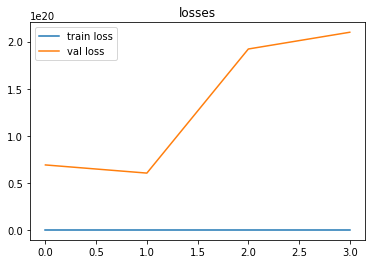

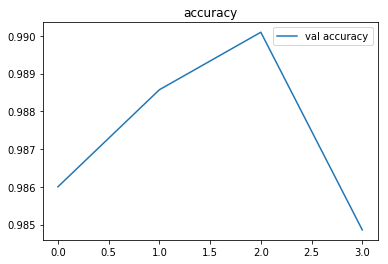

In [9]:

# In[11]:


def train(epochs=2, verbosity=0, val_freq=1):
    num_epochs = epochs
    bs = 64
    rows_trn = len(trn_rows)
    batches_per_epoch = rows_trn // bs
    rows_val = len(val_rows)
    batches_val = rows_val // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        order = np.arange(trn_normalized.shape[0])
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == batches_per_epoch:
                rows = order[itr * bs:]
            samples = rows
            x, y = trn_normalized[samples, :, :, :], trn_Y[samples]
            _, loss, input_x = model(x, tovar(y))

            adv_grad = torch.autograd.grad(loss, input_x, grad_outputs=cuda(torch.ones(loss.size())),
                                           create_graph=True, retain_graph=True, only_inputs=True)
            adv = (adv_grad[0] > 0).type(torch.FloatTensor) * 1e-2 - \
                (adv_grad[0] < 0).type(torch.FloatTensor) * 1e-2
            adv = tonumpy(adv.data)

            x = x + adv

            y_pred, loss, _ = model(x, tovar(y))

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            if itr % 100 == 0:
                print('itr:', itr)
        if epoch % val_freq == 0:
            # Evaluate Performance on on validation set
            # rows_val
            y_pred_all = np.ones((0, 10))
            val_loss_all = 0
            for itr in range(batches_val):
                rows = np.arange(itr * bs, (itr + 1) * bs)
                if itr + 1 == batches_val:
                    rows = np.arange(itr * bs, rows_val)
                xval, yval = val_normalized[rows, :, :, :], val_Y[rows]
                y_pred, loss, _ = model(xval, tovar(yval))
                y_pred_all = np.concatenate((y_pred_all, (tonumpy(y_pred.data))), 0)
                val_loss_all += loss.data[0]
            y_pred_all = np.argmax(y_pred_all, 1)
            acc = (y_pred_all == val_Y).mean()
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            val_loss = tonumpy(val_loss_all)
            print('epoch:', epoch)
            print('train loss: ', trn_loss)
            print('val loss: ', val_loss)
            print('val acc: ', acc)
            trn_loss = []
            model.val_losses.append(val_loss)
            model.val_acc.append(acc)


def visualize(verbosity=0):
    # Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    plt.close()
    plt.plot(model.trn_losses, label='train loss')
    plt.plot(model.val_losses, label='val loss')
    plt.legend()
    plt.title('losses')
    plt.show()
    plt.close()
    plt.plot(model.val_acc, label='val accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()


# Now the code is done so lets test our model with different parameter settings!

# In[12]:


num_epochs = 4
verb = 0
# As in model, hidden layers have order (filters, kernel_size, stride, padding, pool)
# filters is the number of filters in the layer,
# the layer has kernels of shape kernel_size x kernel_size,
# stride is the stride length in each direction
# padding is the padding width in each direction. consider (kernel_size -1)/2
# pool is an indicator for pooling. 0 for convolution, 1 for pooling.

# filters, kernel_size, stride
hidden_layers = [
    [32, 5, 1, 2, 'c'],
    [128, 3, 1, 1, 'r'],
    [64, 5, 2, 2, 'c'],
    [256, 3, 1, 1, 'r'],
    [128, 5, 2, 2, 'c'],
    [32, 3, 1, 1, 'r'],
    [32, 3, 1, 1, 'r'],
    [140, 2, 1, 0, 'c'],
    [32, 3, 1, 1, 'r'],
    [160, 2, 1, 0, 'c'],
    [64, 3, 1, 1, 'r'],
    [200, 2, 1, 0, 'c'],
    [64, 3, 1, 1, 'r'],
    [256, 2, 1, 0, 'c'],
    [360, 2, 1, 0, 'c'],
]


model = cuda(Model(trn_normalized.shape[2], hidden_layers=hidden_layers, num_outputs=10))
x = train(epochs=num_epochs, verbosity=verb)
visualize()



## Now lets visualize the types of features the early layers of the model has learned


In [10]:




weights = tonumpy(model.first_layer.weight.data)


# Code adapted from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, rows=1, titles=None):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    rows
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, np.ceil(n_images / float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()



show_images([weight[0] for weight in weights], rows=4)
